In [1]:
import os
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_X_y

Text(0.5, 1.0, 'Discriminability of different subjects')

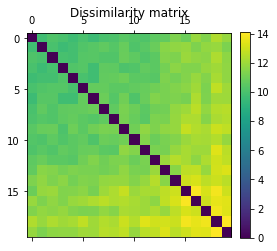

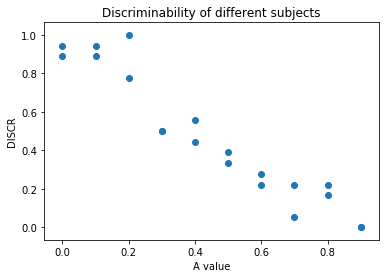

In [2]:
def _discr_rdf(dissimilarities, labels):
    """
    A function for computing the reliability density function of a dataset.

    Parameters
    ----------
    dissimilarities : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the
        dissimilarity matrix.

    labels : 1d-array, shape (n_samples)
        Input labels.

    Returns
    -------
    out : array, shape (n_samples, max{len(id)})
        Rdfs for each sample. Only returned if ``return_rdfs==True``.
    """
    check_X_y(dissimilarities, labels, accept_sparse=True)

    rdfs = []
    for i, label in enumerate(labels):
        di = dissimilarities[i]

        # All other samples except its own label
        idx = labels == label
        Dij = di[~idx]

        # All samples except itself
        idx[i] = False
        Dii = di[idx]

        rdf = [1 - ((Dij < d).sum() + 0.5 * (Dij == d).sum()) / Dij.size for d in Dii]
        rdfs.append(rdf)

    out = np.full((len(rdfs), max(map(len, rdfs))), np.nan)
    for i, rdf in enumerate(rdfs):
        out[i, : len(rdf)] = rdf

    return out


subjects = 10
trials = 2
nodes = 10
win_length = 10
total_length = 100
step_size = 10

measurements = []
times = list(np.arange(0, total_length - win_length + 1, step_size))
time_steps = len(times)
for j in range(subjects):
    A = np.ones(10)*0.1*j  # MAR(1) coefficient matrix
    for s in range(trials):
        # Simulate time series for each trial
        X = np.zeros((nodes, total_length))
        X[:,0] = np.random.normal(size=nodes)
        for i in range(np.size(X,1)-1):
            epsilon = np.random.normal(size=nodes)
            X[:,i+1] = A*X[:,i] + epsilon

        # phi = np.random.uniform(-1,1)
        # ar = np.array([1, -phi])
        # ma = np.array([1])
        # generator = ArmaProcess(ar, ma)
        # X = generator.generate_sample((nodes, total_length), axis=1)

        # Calculate correlation matrix with sliding window mwthod
        features = []

        for i, t in enumerate(times):
            corr_matrix = np.corrcoef(X[:, t:t + step_size])
            features.append(corr_matrix[np.triu_indices(nodes, 1)].flatten())
        measurements.append(np.asarray(features).flatten())

measurements = np.asarray(measurements)
# subjects*trials measurements in total
labels = np.repeat(np.arange(1, subjects + 1), trials)

dissimilarities = euclidean_distances(measurements)
plt.matshow(dissimilarities)
plt.title('Dissimilarity matrix')
plt.colorbar(fraction=0.046, pad=0.04)
rdfs = _discr_rdf(dissimilarities, labels)

plt.figure()
plt.scatter((labels-1)*0.1, rdfs)
plt.xlabel('A value')
plt.ylabel('DISCR')
plt.title('Discriminability of different subjects')